# TensorFlow Tutorial #23
# Time-Series Prediction

In [65]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean



In [21]:
tf.random.set_seed(10)
raw_df = pd.read_csv("../../data/datefrom1st_revised.csv")
raw_df.index = raw_df.datetime

df = raw_df

df = df.drop(
    ["Unnamed: 0", 'datetime', 'percipitation', 'air_pressure', 'sea_level_pressure',
     'wind_degree'], axis=1)
df["difference"] = df.astype('int32')


target_X = df.loc["2020-01-30 00:00:00":"2020-01-30 23:45:00"]


df.drop(df.loc[(df.index > '2020-01-31 00:00:00') & (df.index < '2020-02-01 00:00:00')].index, inplace=True)
df.drop(df.loc[(df.index > '2020-03-31 00:00:00') & (df.index < '2020-04-01 00:00:00')].index, inplace=True)
df.drop(df.loc[(df.index > '2020-05-31 00:00:00') & (df.index < '2020-06-01 00:00:00')].index, inplace=True)
df = df.fillna(0)
df = df.loc[:"2020-01-31 00:00:00"]
TRAIN_SPLIT = int(len(df.index)*0.8)
print(df.head())

dataset = df

shift_days = 1
STEP = 4
shift_steps = shift_days * 24 *4 # Number of hours.
df_targets = df["result"].shift(-shift_steps)
df = df.drop("result", axis=1)
x_data = df.values[0:-shift_steps]
print(type(x_data))
print("Shape:", x_data.shape)
y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)

                     result  temperature  wind_speed   humidity  \
datetime                                                          
2019-07-01 00:00:00     0.0    23.273333    1.193333  84.453333   
2019-07-01 00:15:00     0.0    23.200000    1.306667  84.853333   
2019-07-01 00:30:00     0.0    23.200000    0.646667  85.280000   
2019-07-01 00:45:00     0.0    23.200000    1.053333  85.560000   
2019-07-01 01:00:00     0.0    23.200000    0.973333  85.740000   

                     solar_radiation  solar_intensity  difference  
datetime                                                           
2019-07-01 00:00:00              0.0              0.0           0  
2019-07-01 00:15:00              0.0              0.0           0  
2019-07-01 00:30:00              0.0              0.0           0  
2019-07-01 00:45:00              0.0              0.0           0  
2019-07-01 01:00:00              0.0              0.0           0  
<class 'numpy.ndarray'>
Shape: (20449, 6)
<class 'nump

In [51]:
num_data = len(x_data)
num_data

train_split = 0.8

num_train = int(train_split * num_data)

x_train = x_data[0:num_train]
x_test = x_data[num_train:]

y_train = y_data[0:num_train]
y_test = y_data[num_train:]


num_x_signals = x_data.shape[1]
num_y_signals = 1
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))


x_scaler = MinMaxScaler()


Min: -8.200000000000001
Max: 1032.5314685314695


In [52]:
x_train_scaled = x_scaler.fit_transform(x_train)

Apart from a small rounding-error, the data has been scaled to be between 0 and 1.

In [55]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

x_test_scaled = x_scaler.transform(x_test)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1,1)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

Min: 0.0
Max: 1.0


## Data Generator

The data-set has now been prepared as 2-dimensional numpy arrays. The training-data has almost 300k observations, consisting of 20 input-signals and 3 output-signals.

These are the array-shapes of the input and output data:

In [56]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(16359, 6)
(16359, 1)


Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [57]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        print((batch_size, sequence_length, num_y_signals))
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)


In [58]:
batch_size = 256


In [59]:
sequence_length = 24 * 7 * 4 *4
sequence_length


2688

In [60]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)


In [61]:
x_batch, y_batch = next(generator)


(256, 2688, 1)


In [62]:
print(x_batch.shape)
print(y_batch.shape)

(256, 2688, 6)
(256, 2688, 1)


We can plot one of the 20 input-signals as an example.

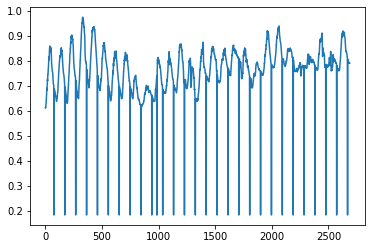

In [68]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

We can also plot one of the output-signals that we want the model to learn how to predict given all those 20 input signals.

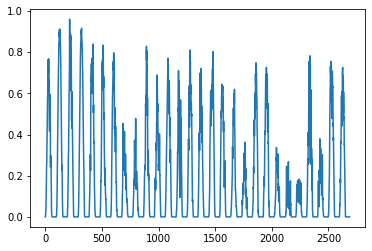

In [69]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [70]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity. See Tutorial #03-C for a tutorial on Keras and Tutorial #20 for more information on Recurrent Neural Networks.

In [71]:
model = Sequential()


In [72]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))


In [73]:
model.add(Dense(num_y_signals, activation='sigmoid'))


In [59]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [74]:
warmup_steps = 50

In [75]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [76]:
optimizer = RMSprop(lr=1e-3)

In [77]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [78]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         798720    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 799,233
Trainable params: 799,233
Non-trainable params: 0
_________________________________________________________________


In [79]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [81]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]


In [82]:
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)


(256, 2688, 1)
Epoch 1/20
(256, 2688, 1)
  6/100 [>.............................] - ETA: 52:00 - loss: 0.0835(256, 2688, 1)


KeyboardInterrupt: 

In [71]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))


print("loss (test-set):", result)

In [ ]:
y_train

In [74]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))


def plot_comparison(train=True, name = "out"):
    """
    Plot the predicted and true output-signals.
    
    :param name: 
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    signal_pred = y_pred_rescaled
    signal_true = y_true

    plt.figure(figsize=(15,5))
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
    
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.ylabel("PV output")
    plt.legend()
    plt.show()
    plt.savefig(name+".png")


In [83]:
plot_comparison(train=True, name="out1")


NameError: name 'plot_comparison' is not defined

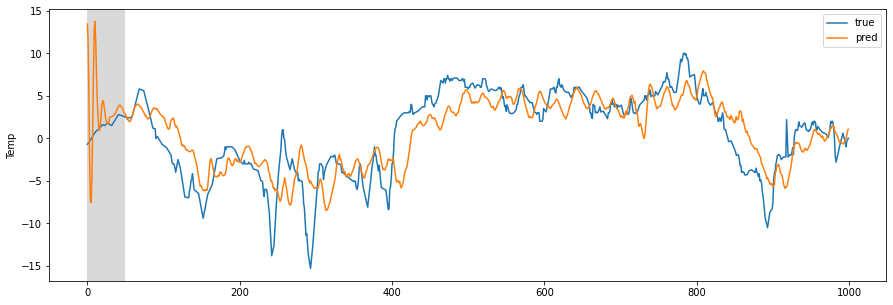

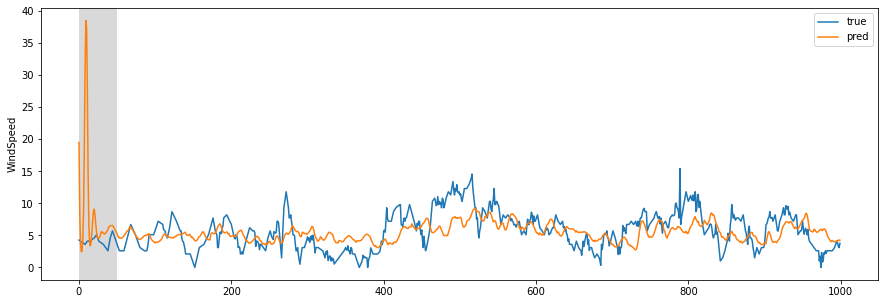

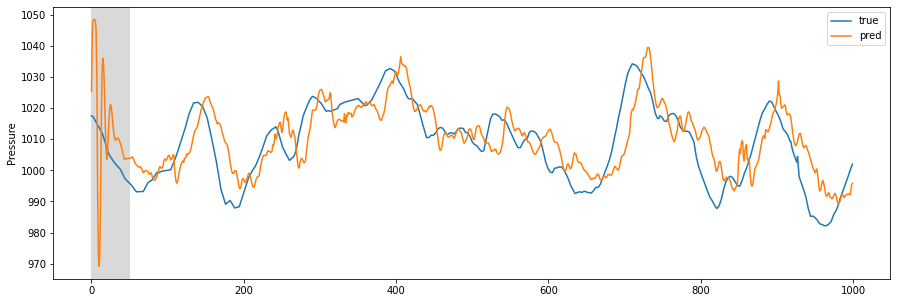

In [77]:
plot_comparison(train=True, name="out2")